In [ ]:
import csv
import requests
from bs4 import BeautifulSoup
import re
import os.path
import json
from tqdm import tqdm
import pickle 
import google.auth
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
import pandas as pd 

In [110]:
# If modifying these SCOPES, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

def get_sheet_names_and_ids(spreadsheet_id, creds_file, token_file):
    creds = None
    if os.path.exists(token_file):
        creds = Credentials.from_authorized_user_file(token_file, SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(creds_file, SCOPES)
            creds = flow.run_local_server(port=0)
        with open(token_file, 'w') as token:
            token.write(creds.to_json())
    
    service = build('sheets', 'v4', credentials=creds)
    sheet_metadata = service.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()
    sheets = sheet_metadata.get('sheets', '')
    
    result = []
    for sheet in sheets:
        sheet_name = sheet.get("properties", {}).get("title", "")
        sheet_id = sheet.get("properties", {}).get("sheetId", "")
        result.append({'name': sheet_name, 'gid': sheet_id})
    
    return result

if __name__ == '__main__':
    # Replace with your Google Sheets ID and path to your credentials file
    SPREADSHEET_ID = '1BgP_mbAc7kn1rxV6_ROBbG-WOoVBX5hD5xfgFbqxQDU'
    CREDS_FILE = '/Users/lukasfrosslund/code/emtips2021excel/client_secret_980160792434-27i3kn32iu3n9qqkq43s6maefuhakfin.apps.googleusercontent.com.json'
    TOKEN_FILE = 'token.json'

    sheets_info = get_sheet_names_and_ids(SPREADSHEET_ID, CREDS_FILE, TOKEN_FILE)
    for sheet in sheets_info:
        print(f"Sheet Name: {sheet['name']}, GID: {sheet['gid']}")


Sheet Name: Resultat & Tabell, GID: 1629140317
Sheet Name: Poäng & instruktioner, GID: 778307614
Sheet Name: Mallen, GID: 1459532883
Sheet Name: Jacob Hjorth, GID: 1705896954
Sheet Name: Adrian Brånemark, GID: 845560671
Sheet Name: David Carlsson, GID: 1171244747
Sheet Name: Felix Andersson, GID: 1501103698
Sheet Name: Erik Gustafsson, GID: 1569051184
Sheet Name: Karin Kelvered, GID: 1639552023
Sheet Name: Matilda Svensson, GID: 3135272
Sheet Name: Jesper Engström, GID: 1680690303
Sheet Name: Andreas Roddan Eriksson, GID: 1892456296
Sheet Name: Jesper Mattsson, GID: 148370873
Sheet Name: Erik Dewall, GID: 1479616826
Sheet Name: Cajsa Eriksson, GID: 1465098272
Sheet Name: Robert Lidhammar, GID: 600558285
Sheet Name: Noel Andersson, GID: 1058970280
Sheet Name: Robert Johansson, GID: 234386403
Sheet Name: Adam Blixt, GID: 1962957473
Sheet Name: Sebastian Jarlenäs, GID: 629012500
Sheet Name: Per Nykvist, GID: 1008746028
Sheet Name: Jonathan Lagerquist, GID: 354437640
Sheet Name: Peter Lars

In [112]:
sheets_info = sheets_info[3:]

In [172]:
df_stats = {}
completeSpreadsheetIdx = "1BgP_mbAc7kn1rxV6_ROBbG-WOoVBX5hD5xfgFbqxQDU"
for sheet in tqdm(sheets_info):
    participant = sheet['name']
    sheet_idx = sheet['gid']
    df_stats[sheet_idx] = {}
    df_stats[sheet_idx]['name'] = participant

    url = f"https://docs.google.com/spreadsheets/d/{completeSpreadsheetIdx}/export?format=csv&gid={sheet_idx}"
    curr_df = pd.read_csv(url)
    df_stats[sheet_idx]['winner'] = curr_df.iloc[2, 24]
    df_stats[sheet_idx]['topscorer'] = curr_df.iloc[3, 24]
    df_stats[sheet_idx]['most_goals_scores'] = curr_df.iloc[4, 24]
    df_stats[sheet_idx]['most_goals_conceeded'] = curr_df.iloc[5, 24]
    df_stats[sheet_idx]['extra_time'] = curr_df.iloc[6, 24]
    df_stats[sheet_idx]['red_cards'] = curr_df.iloc[7, 24]
    
    df_stats[sheet_idx]['matches'] = []
    match_idx = 2
    while match_idx <= 52:
        for i in range(6):
            df_stats[sheet_idx]['matches'].append(
                {
                    'home': curr_df.iloc[match_idx, 3],
                    'away': curr_df.iloc[match_idx, 5],
                    'home_goals': int(float(curr_df.iloc[match_idx, 6])),
                    'away_goals': int(float(curr_df.iloc[match_idx, 8])),
                    'sign': curr_df.iloc[match_idx, 9],
                }
            )
            match_idx += 1
        match_idx += 3
    
    df_stats[sheet_idx]['roundofsixteen'] = []
    match_idx = 56
    while match_idx <= 63:
        df_stats[sheet_idx]['roundofsixteen'].append(curr_df.iloc[match_idx, 3])
        df_stats[sheet_idx]['roundofsixteen'].append(curr_df.iloc[match_idx, 5])
        match_idx += 1
    
    df_stats[sheet_idx]['quarterfinals'] = []
    match_idx = 67
    while match_idx <= 70:
        df_stats[sheet_idx]['quarterfinals'].append(curr_df.iloc[match_idx, 3])
        df_stats[sheet_idx]['quarterfinals'].append(curr_df.iloc[match_idx, 5])
        match_idx += 1
    
    df_stats[sheet_idx]['semifinals'] = []
    match_idx = 74
    while match_idx <= 75:
        df_stats[sheet_idx]['semifinals'].append(curr_df.iloc[match_idx, 3])
        df_stats[sheet_idx]['semifinals'].append(curr_df.iloc[match_idx, 5])
        match_idx += 1
    
    df_stats[sheet_idx]['final'] = []
    df_stats[sheet_idx]['final'].append(curr_df.iloc[79, 3])
    df_stats[sheet_idx]['final'].append(curr_df.iloc[79, 5])


100%|██████████| 68/68 [07:13<00:00,  6.37s/it]


In [198]:
names = []

home = 'Serbien'
away = 'England'

home_goals = '0'
away_goals = '1'

for key in df_stats:
    for match in df_stats[key]['matches']:
        if match['home'] == home and match['away'] == away and str(match['home_goals']) == home_goals and str(match['away_goals']) == away_goals:
            names.append(df_stats[key]['name'])

names

['Karin Kelvered', 'Cajsa Eriksson', 'Elin Brånemark', 'Pontus Lundgren']

In [194]:
# comma separated list of names
print(', '.join(names))

Jesper Mattsson, Cajsa Eriksson, Jonny Frösslund, Ida Reinholdsson, Joakim Ödlund, Patric Hjorth, Alicia Brånemark, Lukas Frösslund, Valdemar Gezelius


In [ ]:
def dump_pickle(df, name):
    picklefile = open(name, 'wb')
    pickle.dump(df, picklefile)
    picklefile.close()
    print("Pickle dumped and picklefile closed.")


def load_pickle(name):
    picklefile = open(name, 'rb')
    df = pickle.load(picklefile)
    return df

In [29]:
dump_pickle(df_stats, "all_sa")

Pickle dumped and picklefile closed.


In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
topscorers = {}
for key in df_stats.keys():
    topscorer = df_stats[key]['topscorer']
    if topscorer.lower() == "mitrovic":
        print(key)
    if topscorer in topscorers:
        topscorers[topscorer] += 1
    else:
        topscorers[topscorer] = 1

1964634616


In [124]:
topscorers['Kylian Mbappé'] = 34

In [126]:
topscorers['Cristiano Ronaldo'] = 3

In [154]:
topscorers['Aleksandar Mitrovic'] = 1

In [161]:
del topscorers['Harry Kane ']

In [162]:
topscorers

{'Kylian Mbappé': 34,
 'Harry Kane': 18,
 'Cristiano Ronaldo': 3,
 'Jude Bellingham': 2,
 'Bukayo Saka': 2,
 'Alvaro Morata': 1,
 'Kai Havertz': 3,
 'Romelu Lukaku': 2,
 'Rafael Leao': 1,
 'Phil Foden': 1,
 'Aleksandar Mitrovic': 1}

/var/folders/k0/jwj71hc55md02dcytnxyr9s80000gn/T/ipykernel_79121/2406117691.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barp = sns.barplot(x=y, y=x, palette="viridis", ax=ax)


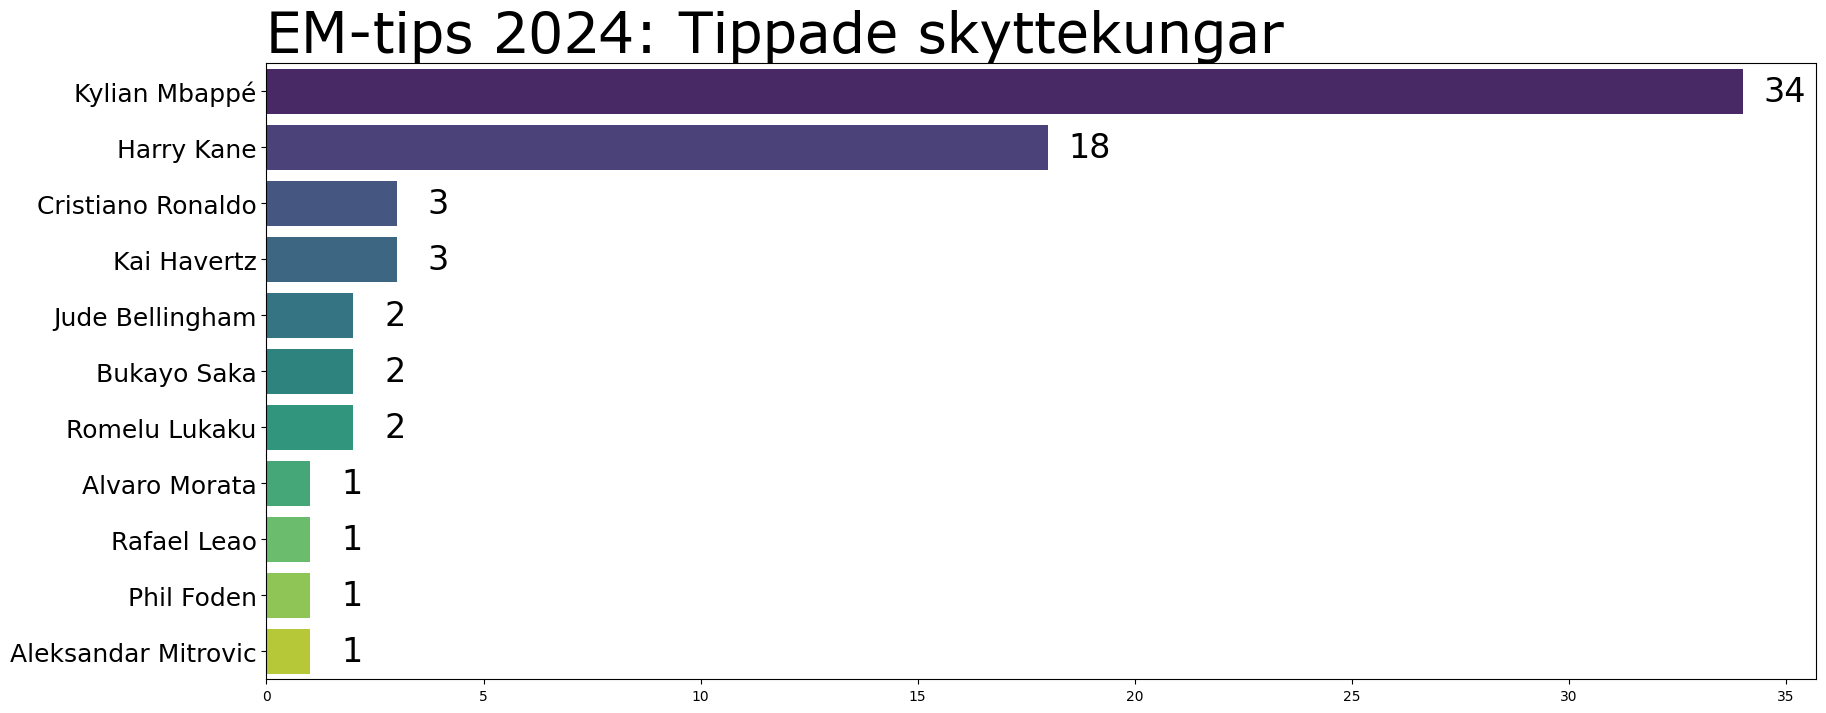

In [164]:
create_horizontal_plot(topscorers, "EM-tips 2024: Tippade skyttekungar", "skyttekung")

In [163]:
sum(topscorers.values())

68

In [30]:
df = df_stats

In [31]:
winners = {}
for key in df.keys():
    winner = df[key]['winner']
    if winner in winners:
        winners[winner] += 1
    else:
        winners[winner] = 1

In [32]:
winners

{'Frankrike': 36,
 'England': 12,
 'Portugal': 3,
 'Spanien': 2,
 'Tyskland': 12,
 'Italien': 2,
 'Nederländerna': 1}

In [35]:
sorted_winners = dict(sorted(winners.items(), key=lambda item: item[1], reverse=True))

In [36]:
sorted_winners

{'Frankrike': 36,
 'England': 12,
 'Tyskland': 12,
 'Portugal': 3,
 'Spanien': 2,
 'Italien': 2,
 'Nederländerna': 1}

In [33]:
list(winners.values())

[36, 12, 3, 2, 12, 2, 1]

In [44]:
from matplotlib.font_manager import FontProperties

In [79]:
def create_plot(data, headline, filename, to_sort=True):
    if to_sort:
        data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    x = np.array(list(data.keys()))
    y = np.array(list(data.values()))
    dims = (20, 8)
    fig, ax = plt.subplots(figsize=dims)
    barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)

    # Add values on top of each bar as integers and make the text larger and bold
    for p in ax.patches:
        ax.annotate(format(int(p.get_height()), 'd'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 10),  # 9 points vertical offset
                    textcoords = 'offset points',
                    fontsize=24)  # larger and bold text

    # Custom font properties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Verdana')
    font.set_size(40)

    # Add a title to the plot
    ax.set_title(headline, loc='left', fontproperties=font)
    ax.tick_params(axis='x', labelsize=18)

    fig = barp.get_figure()
    fig.savefig(dpi=300, fname=f"plots/{filename}")

In [93]:
def create_horizontal_plot(data, headline, filename, to_sort=True):
    if to_sort:
        data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    x = np.array(list(data.keys()))
    y = np.array(list(data.values()))
    dims = (20, 8)
    fig, ax = plt.subplots(figsize=dims)
    barp = sns.barplot(x=y, y=x, palette="viridis", ax=ax)

    # Add values next to each bar as integers and make the text larger and bold
    for p in ax.patches:
        ax.annotate(format(int(p.get_width()), 'd'),
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha = 'center', va = 'center',
                    xytext = (30, 0),  # horizontal offset
                    textcoords = 'offset points',
                    fontsize=24)  # larger and bold text

    # Custom font properties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Verdana')
    font.set_size(40)

    # Add a title to the plot
    ax.set_title(headline, loc='left', fontproperties=font)
    ax.tick_params(axis='y', labelsize=18)

    fig = barp.get_figure()
    fig.savefig(dpi=300, fname=f"plots/{filename}")

/var/folders/k0/jwj71hc55md02dcytnxyr9s80000gn/T/ipykernel_79121/4063048186.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)


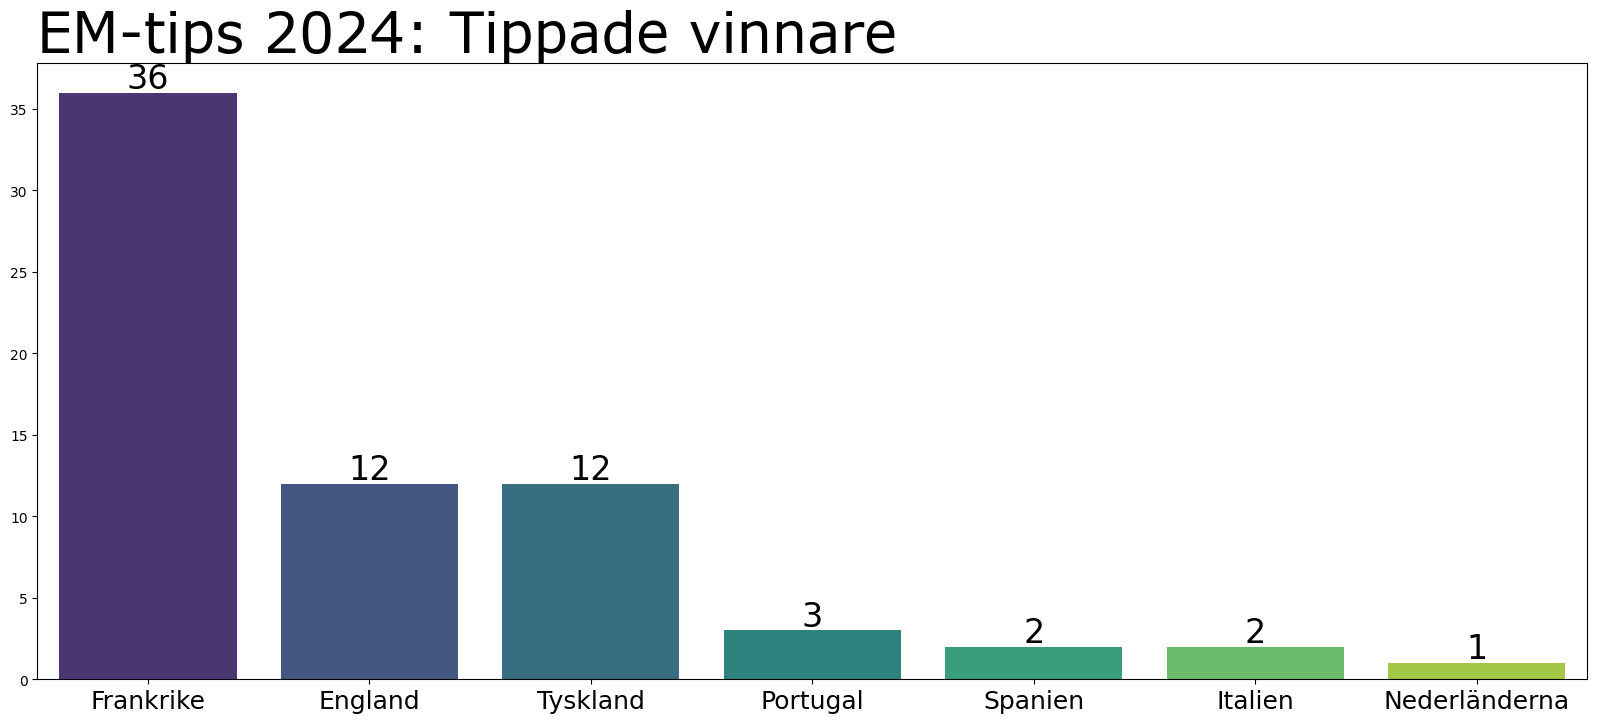

In [67]:

x = np.array(list(sorted_winners.keys()))
y = np.array(list(sorted_winners.values()))
dims = (20, 8)
fig, ax = plt.subplots(figsize=dims)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)

# Add values on top of each bar as integers and make the text larger and bold
for p in ax.patches:
    ax.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),  # 9 points vertical offset
                textcoords = 'offset points',
                fontsize=24)  # larger and bold text

# Custom font properties
font = FontProperties()
font.set_family('serif')
font.set_name('Verdana')
font.set_size(40)

# Add a title to the plot
ax.set_title("EM-tips 2024: Tippade vinnare", loc='left', fontproperties=font)
ax.tick_params(axis='x', labelsize=18)

fig = barp.get_figure()
fig.savefig(dpi=300, fname="plots/winners")

In [83]:
all_matches = [f"{m['home']} - {m['away']}" for m in df_stats[1705896954]['matches']]

In [ ]:
for match in all_matches:
    scores = {}
    for gid, sheet in df.items():
        for eval_match in sheet['matches']:
            if f"{eval_match['home']} - {eval_match['away']}" == match:
                expected_result = f"{eval_match['home_goals']} - {eval_match['away_goals']}"
                if expected_result in scores:
                    scores[expected_result] += 1
                else:
                    scores[expected_result] = 1
    create_plot(scores, f"EM-tips 2024: {match}", match.replace(' - ', '_'))

In [187]:
for key in df_stats.keys():
    if 'Nederländerna' in df_stats[key]['final']:
        print(df_stats[key]['name'])
        print(df_stats[key]['final'])

Jesper Engström
['Nederländerna', 'Frankrike']
Peter Larsson
['Nederländerna', 'England']
Ted Karlsson
['Nederländerna', 'Belgien']
Anna-Tove Brånemark
['Tyskland', 'Nederländerna']


In [89]:
in_final = {}
for key in df.keys():
    finalTeams = df[key]['semifinals']
    team_1, team_2 = finalTeams
    if team_1 in in_final:
        in_final[team_1] += 1
    else:
        in_final[team_1] = 1
    if team_2 in in_final:
        in_final[team_2] += 1
    else:
        in_final[team_2] = 1

ValueError: too many values to unpack (expected 2)

/var/folders/k0/jwj71hc55md02dcytnxyr9s80000gn/T/ipykernel_79121/709698828.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)


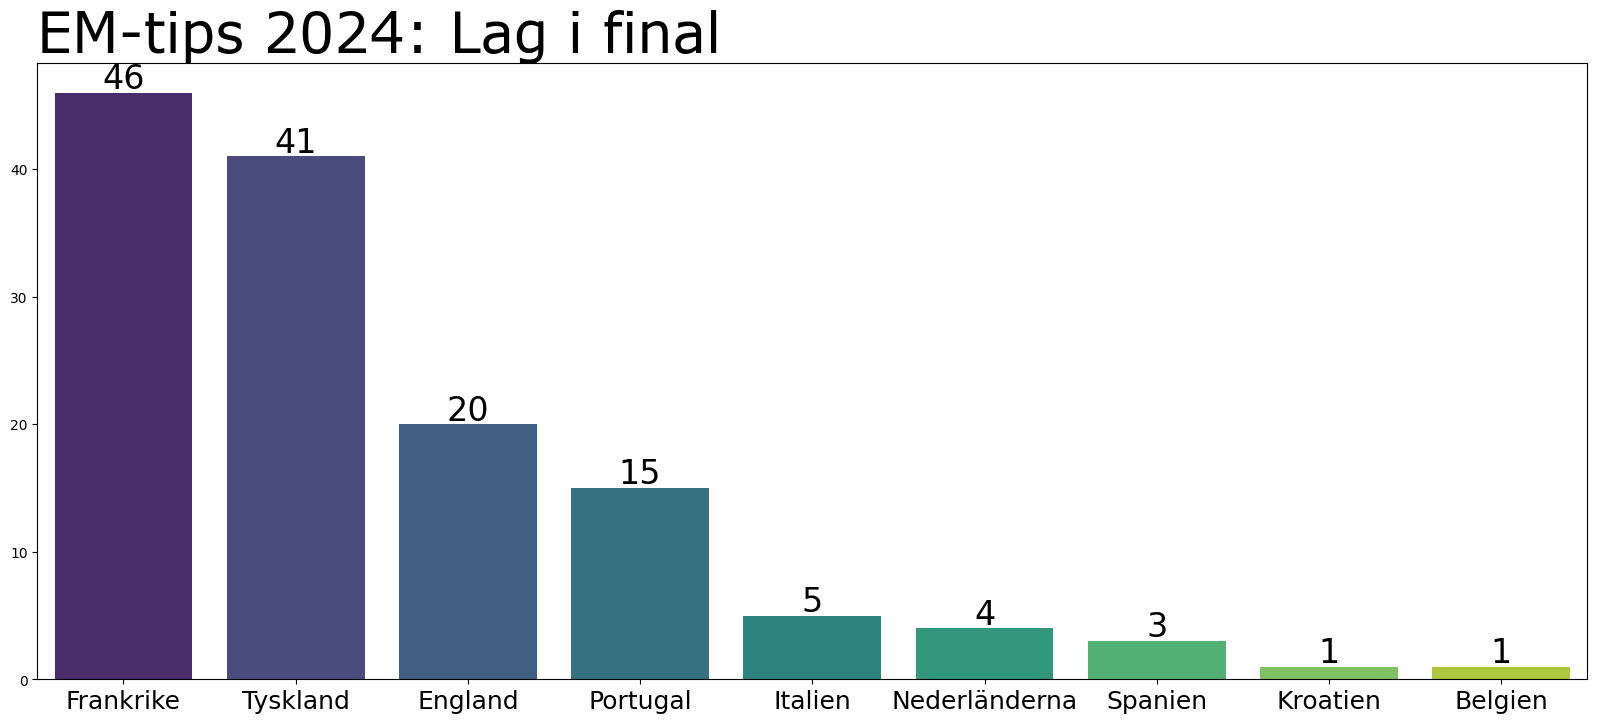

In [87]:
create_plot(in_final, "EM-tips 2024: Lag i final", "lag_i_final")

In [71]:
test = sorted(in_final.values())

In [76]:
in_final_sorted = {k: v for k, v in sorted(in_final.items(), key=lambda item: item[1], reverse=True)}

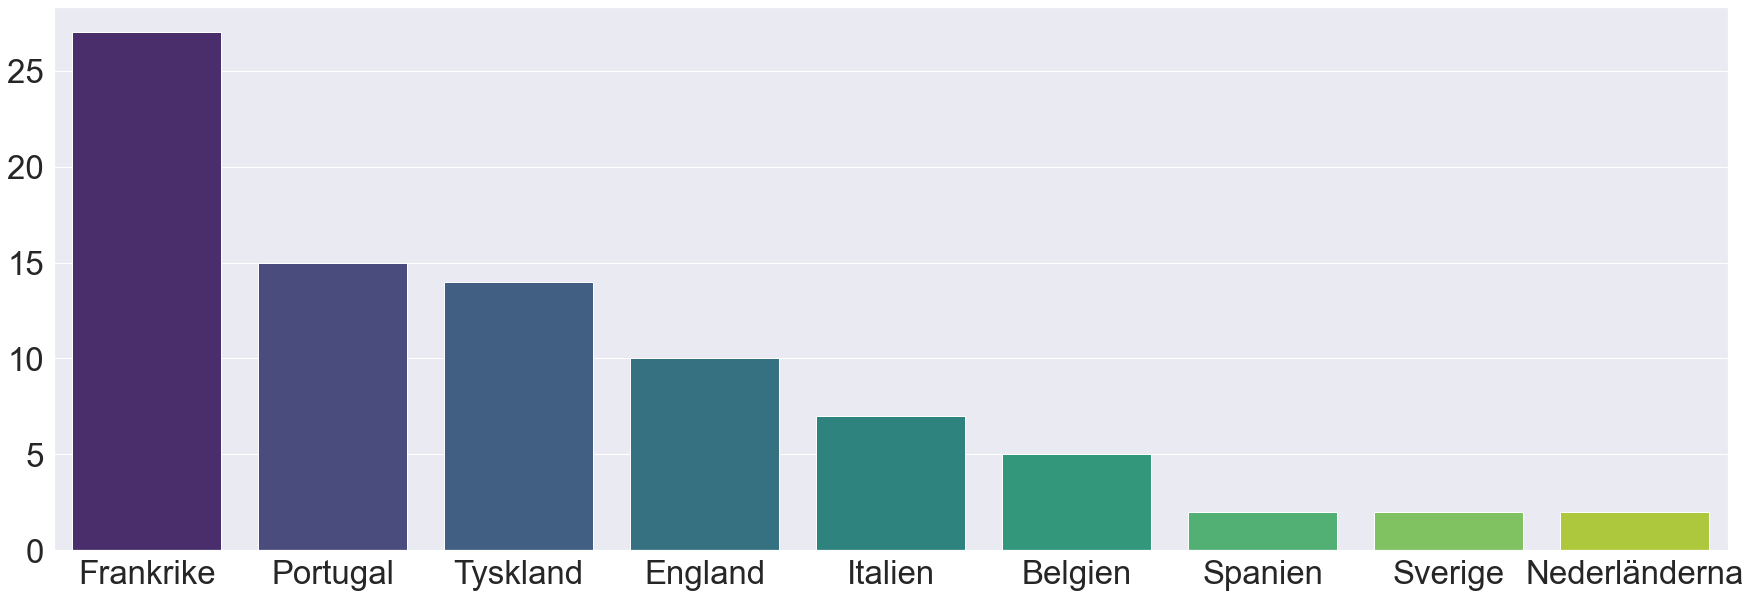

In [79]:
x = np.array(list(in_final_sorted.keys()))
y = np.array(list(in_final_sorted.values()))
dims = (30, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 3)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_final_plot")

In [95]:
in_semifinal = {}
for key in df.keys():
    semiTeams = df[key]['semifinals']
    for team in semiTeams:
        team = team.capitalize()
        if team in in_semifinal:
            in_semifinal[team] += 1
        else:
            in_semifinal[team] = 1

/var/folders/k0/jwj71hc55md02dcytnxyr9s80000gn/T/ipykernel_79121/2406117691.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barp = sns.barplot(x=y, y=x, palette="viridis", ax=ax)


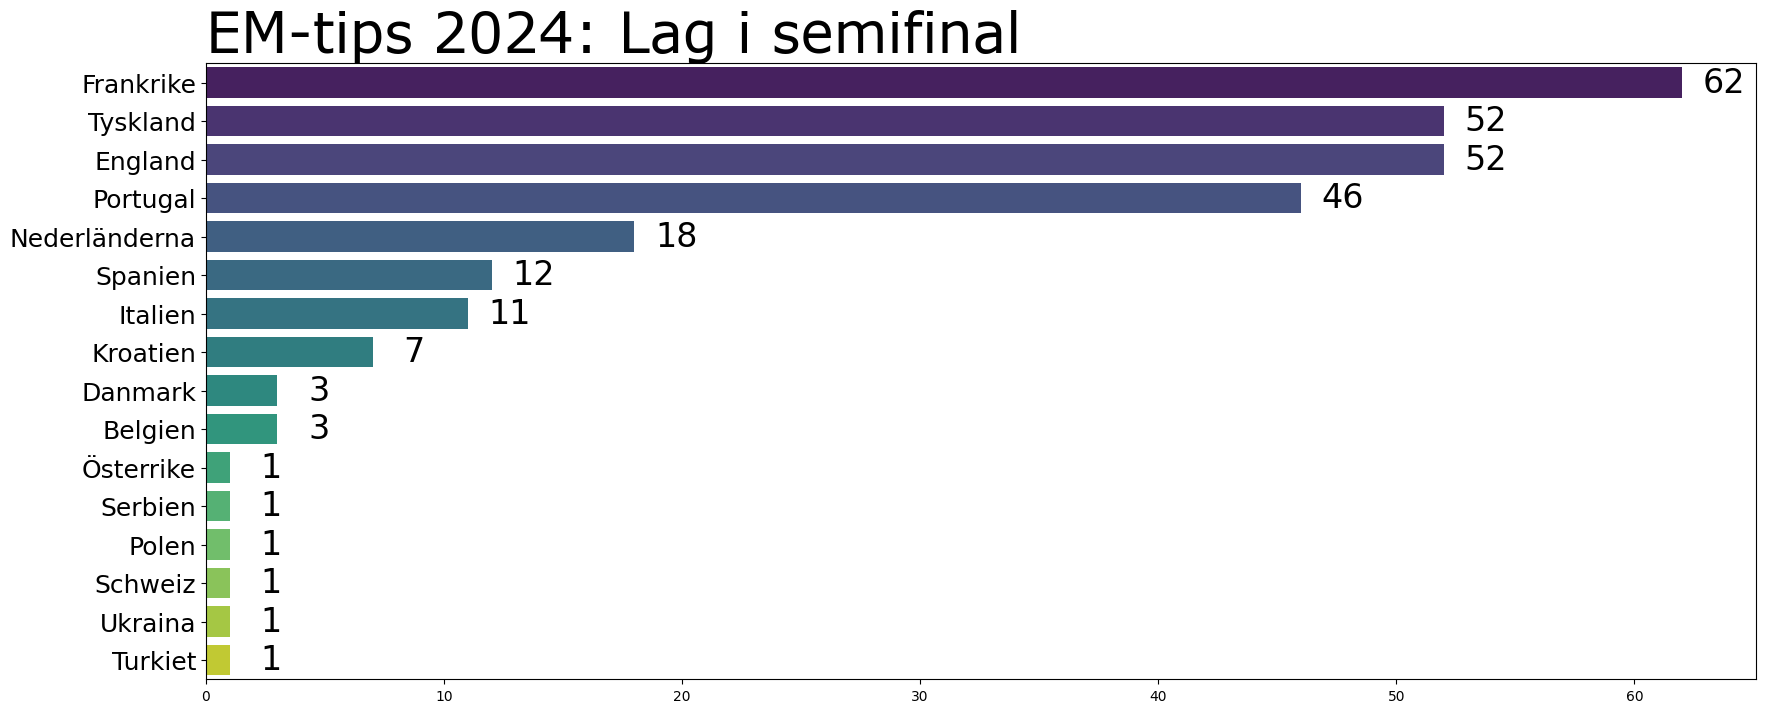

In [96]:
create_horizontal_plot(in_semifinal, "EM-tips 2024: Lag i semifinal", "lag_i_semifinal")

In [100]:
in_quarterfinal = {}
for key in df.keys():
    teams = df[key]['quarterfinals']
    for team in teams:
        team = team.capitalize()
        if team == 'Österrrike':
            team = 'Österrike'
        if team in in_quarterfinal:
            in_quarterfinal[team] += 1
        else:
            in_quarterfinal[team] = 1

/var/folders/k0/jwj71hc55md02dcytnxyr9s80000gn/T/ipykernel_79121/2406117691.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barp = sns.barplot(x=y, y=x, palette="viridis", ax=ax)


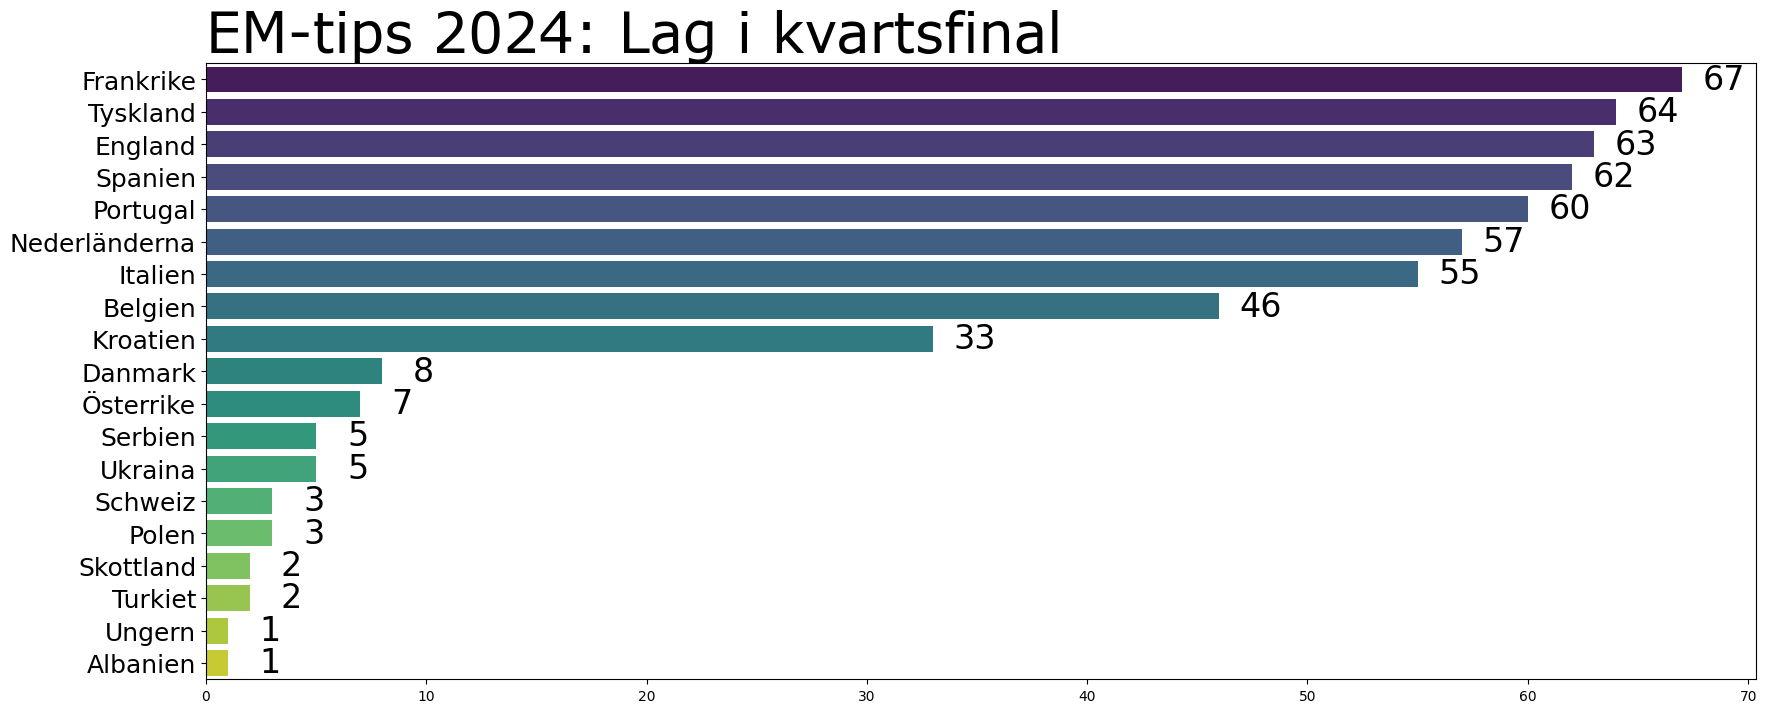

In [101]:
create_horizontal_plot(in_quarterfinal, "EM-tips 2024: Lag i kvartsfinal", "lag_i_kvartsfinal")

In [170]:
df = df_stats

In [171]:
in_sixteen = {}
for key in df.keys():
    teams = df[key]['roundofsixteen']
    for team in teams:
        team = team.capitalize()
        if team in ["#value!", "nan"]:
            print(key) 
        if team == 'Österrrike':
            team = 'Österrike'
        if team in in_sixteen:
            in_sixteen[team] += 1
        else:
            in_sixteen[team] = 1

1465098272
1465098272


AttributeError: 'float' object has no attribute 'capitalize'

/var/folders/k0/jwj71hc55md02dcytnxyr9s80000gn/T/ipykernel_79121/2406117691.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barp = sns.barplot(x=y, y=x, palette="viridis", ax=ax)


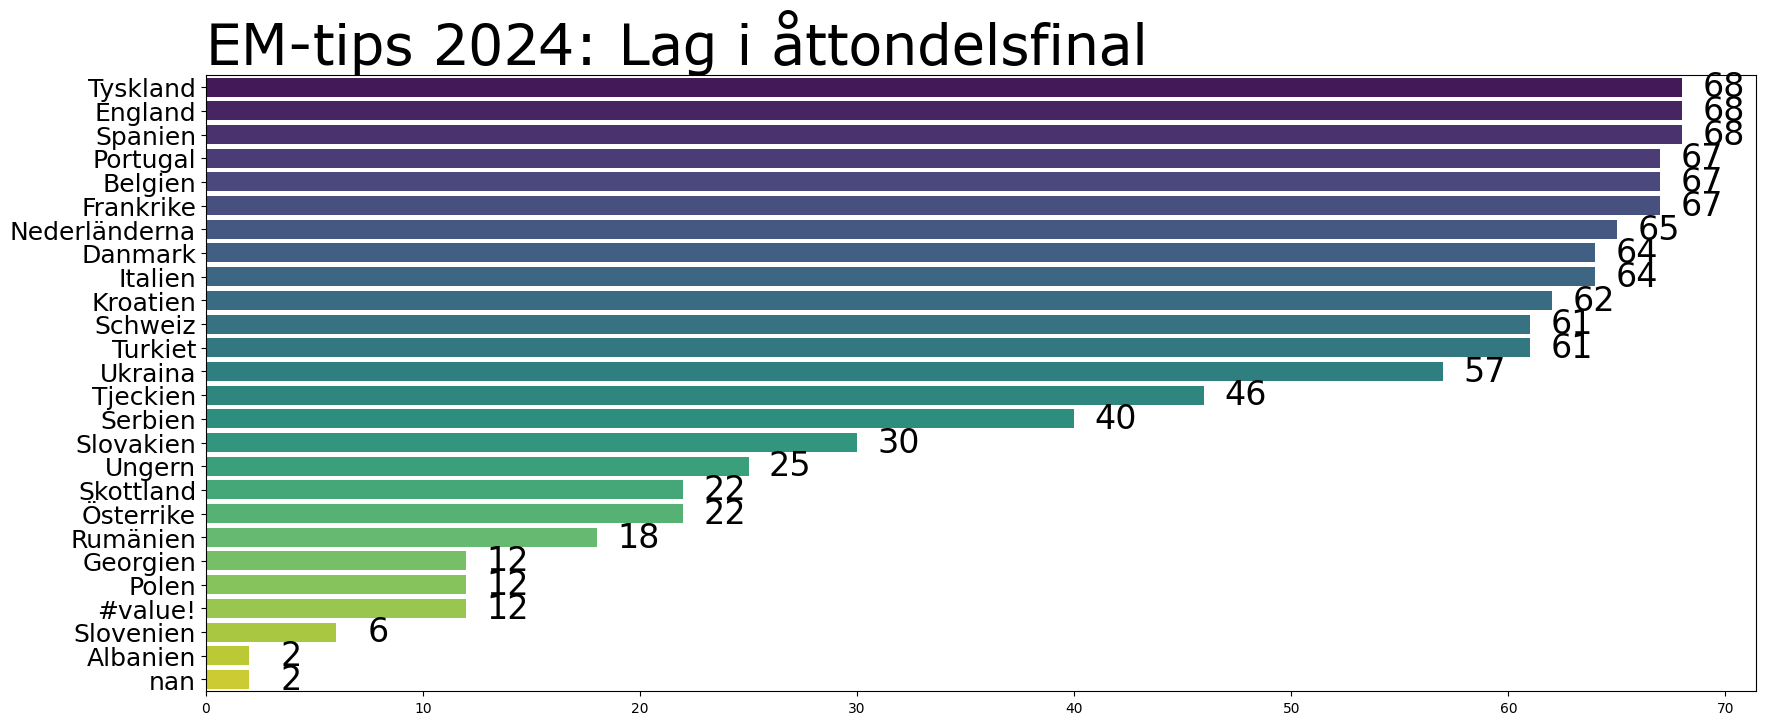

In [166]:
create_horizontal_plot(in_sixteen, "EM-tips 2024: Lag i åttondelsfinal", "lag_i_åttondelsfinal")

In [78]:
in_semifinal_sorted = {k: v for k, v in sorted(in_semifinal.items(), key=lambda item: item[1], reverse=True)}

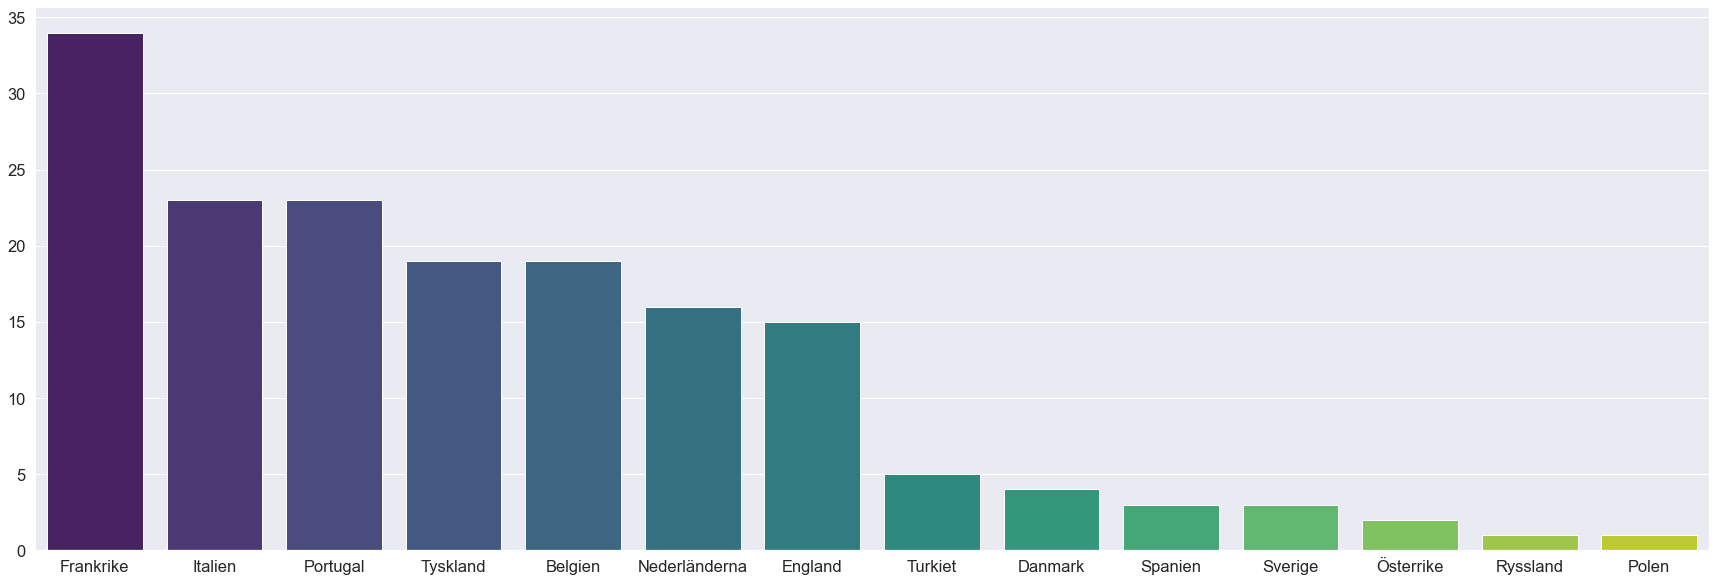

In [82]:
x = np.array(list(in_semifinal_sorted.keys()))
y = np.array(list(in_semifinal_sorted.values()))
dims = (30, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 1.5)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_semifinal_plot")

In [49]:
in_quarterfinal = {}
for key in df.keys():
    quarterTeams = df[key]['quarterfinals']
    for team in quarterTeams:
        if team in in_quarterfinal:
            in_quarterfinal[team] += 1
        else:
            in_quarterfinal[team] = 1

In [85]:
in_quarterfinal_sorted = {k: v for k, v in sorted(in_quarterfinal.items(), key=lambda item: item[1], reverse=True)}

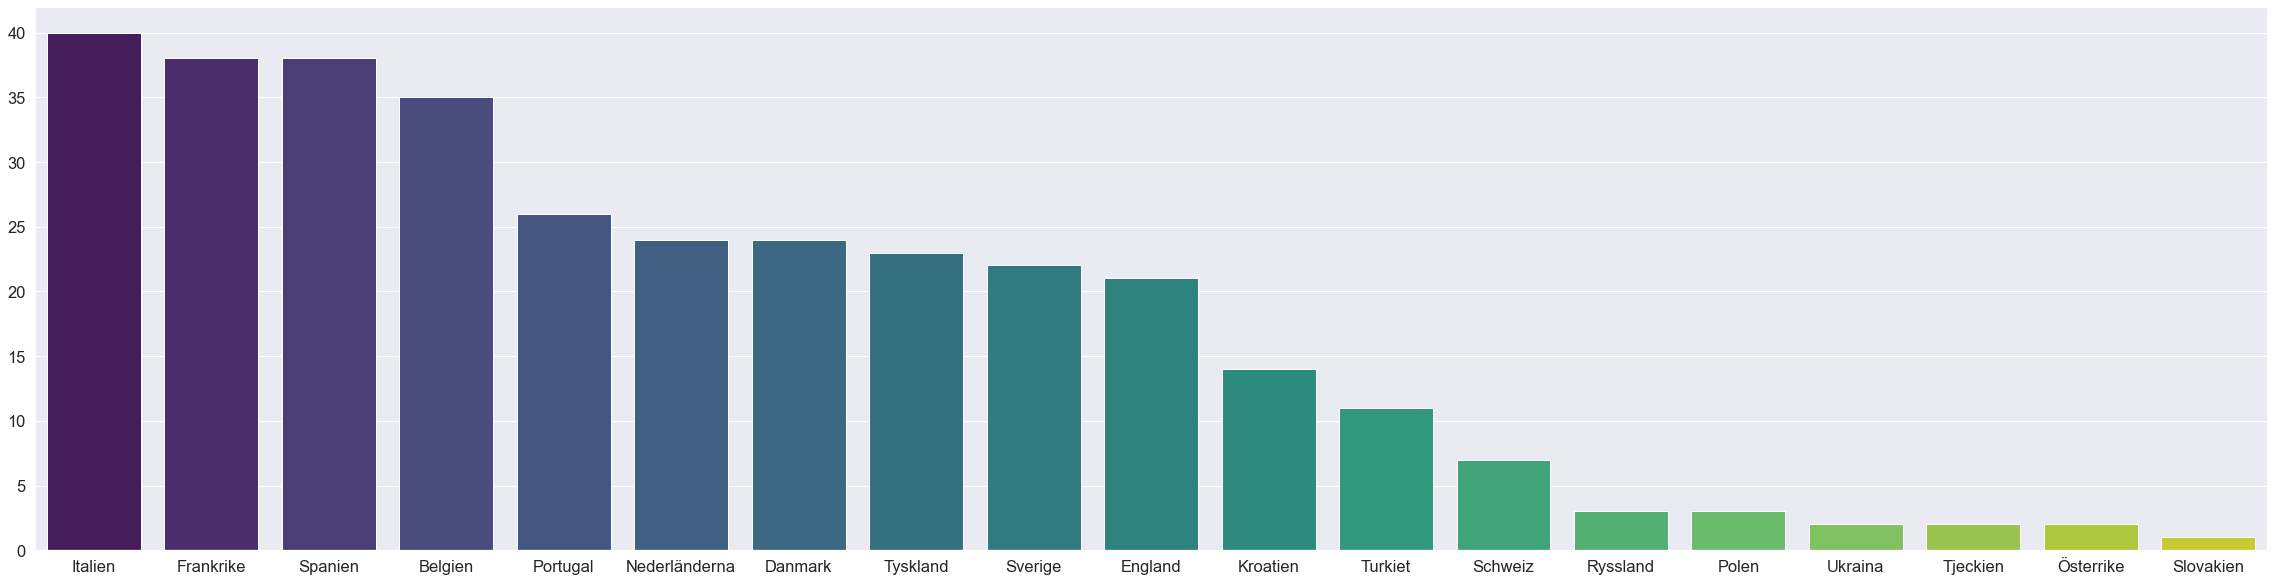

In [89]:
x = np.array(list(in_quarterfinal_sorted.keys()))
y = np.array(list(in_quarterfinal_sorted.values()))
dims = (40, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 1.5)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_quarterfinal_plot")

In [51]:
in_sixteen = {}
for key in df.keys():
    sixteenTeams = df[key]['roundofsixteen']
    for team in sixteenTeams:
        if team in in_sixteen:
            in_sixteen[team] += 1
        else:
            in_sixteen[team] = 1

In [90]:
in_sixteen_sorted = {k: v for k, v in sorted(in_sixteen.items(), key=lambda item: item[1], reverse=True)}

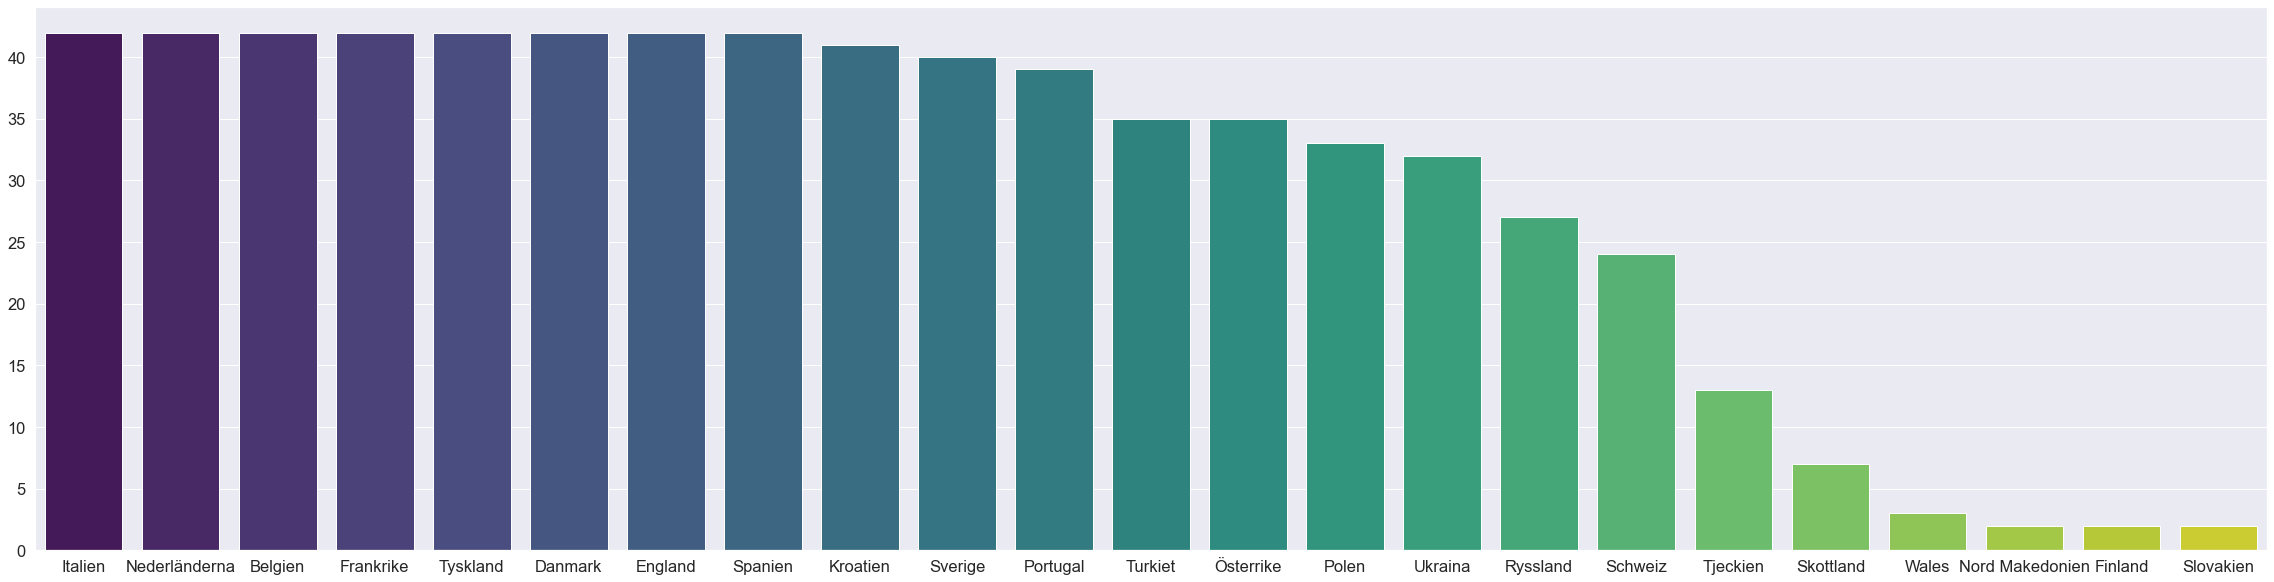

In [92]:
x = np.array(list(in_sixteen_sorted.keys()))
y = np.array(list(in_sixteen_sorted.values()))
dims = (40, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 1.5)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_sixteen_plot")